# Read the data

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import time
from datetime import datetime
from datetime import date

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the data
df= pd.read_csv("UK Road Accidents 2018.csv")

### Random sample of data
shows more variation in the data set than df.head(). Data set is usually sorted during ETL process.

In [3]:
df.sample(5)

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area
5658,31/08/2018 04:00,3,Friday,Fine,False,Dry,Daylight,Urban
5684,01/09/2018 06:00,6,Saturday,Fine,False,Dry,Daylight,Urban
7840,02/12/2018 02:00,7,Sunday,Raining,False,Wet or damp,Darkness - lights lit,Urban
1855,22/03/2018 01:00,2,Thursday,Raining,False,Wet or damp,Darkness - no lighting,Rural
4414,09/07/2018 05:00,1,Monday,Fine,False,Dry,Daylight,Rural


### Check for nulls

Non-null count provides the same as " RangeIndex - df.isna().sum()"

RangeIndex: 8540

All Non_Null Counts = 8540

**Therefore Nulls are not present in this data set.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8540 entries, 0 to 8539
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   datetime                 8540 non-null   object
 1   Count                    8540 non-null   int64 
 2   Day_of_Week              8540 non-null   object
 3   Precipitation            8540 non-null   object
 4   High_Winds               8540 non-null   bool  
 5   Road_Surface_Conditions  8540 non-null   object
 6   Light_Conditions         8540 non-null   object
 7   Urban_or_Rural_Area      8540 non-null   object
dtypes: bool(1), int64(1), object(6)
memory usage: 475.5+ KB


In [5]:
for column in df.columns:
    if len(df[df[column] == "Data missing or out of range"])+ len(df[df[column] == "Other"]) > 0:
        print(column)
        print(len(df[df[column] == "Data missing or out of range"]))
        df.drop(df[df[column] == "Data missing or out of range"].index, inplace = True) 
        
        print(len(df[df[column] == "Other"]))
        df.drop(df[df[column] == "Other"].index, inplace = True) 
        
        print(len(df[df[column] == "Unknown"]))
        df.drop(df[df[column] == "Unknown"].index, inplace = True)

Precipitation
1
51
48
Road_Surface_Conditions
2
0
0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8438 entries, 0 to 8539
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   datetime                 8438 non-null   object
 1   Count                    8438 non-null   int64 
 2   Day_of_Week              8438 non-null   object
 3   Precipitation            8438 non-null   object
 4   High_Winds               8438 non-null   bool  
 5   Road_Surface_Conditions  8438 non-null   object
 6   Light_Conditions         8438 non-null   object
 7   Urban_or_Rural_Area      8438 non-null   object
dtypes: bool(1), int64(1), object(6)
memory usage: 535.6+ KB


In [7]:
df2 = df

##  Dr Strange 

### Function TimeSplit
It takes datetime column and derives following new features:
* Hour (0-23)
* dayofweek (1-7)
* quarter (1-4)
* month(1-12)
* dayofyear (1-365)
* dayofmonth(1-31)
* weekofyear(1-52)

Extracting year does not serve any purpose as data set contains only 2018.

In [8]:
def TimeSplit(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['datetime'] = pd.to_datetime(df['datetime'], format="%d/%m/%Y %H:%M" , errors='coerce')
    df['Hour'] = df['datetime'].dt.hour
    df['Dayofweek'] = df['datetime'].dt.dayofweek+1
    df['Quarter'] = df['datetime'].dt.quarter
    df['Month'] = df['datetime'].dt.month
    #df['year'] = df['Date'].dt.year
    #df['dayofyear'] = df['datetime'].dt.dayofyear
    df['Dayofmonth'] = df['datetime'].dt.day
    df['Weekofyear'] = df['datetime'].dt.weekofyear
    
    
    X = df[['Hour','Dayofweek','Quarter','Month',
            #'year','dayofyear',
            'Dayofmonth','Weekofyear']]
    return X

In [9]:
TimeSplit(df)

,Hour,Dayofweek,Quarter,Month,Dayofmonth,Weekofyear
0,0,1,1,1,1,1
1,1,1,1,1,1,1
2,2,1,1,1,1,1
3,3,1,1,1,1,1
4,4,1,1,1,1,1
...,...,...,...,...,...,...
8535,19,1,4,12,31,1
8536,20,1,4,12,31,1
8537,21,1,4,12,31,1
8538,22,1,4,12,31,1


### Function TimeOfDay 

It takes hour derived with the previous function and splits in 5 categories:
* morning rush (5-10)
* office hours (10-15)
* afternoon rush (15-19)
* evening (19-23)
* night (23-5)

In [10]:
def TimeOfDay(hour):
    if hour >= 5 and hour < 10:
        return "Morning rush (5-10)"
    elif hour >= 10 and hour < 15:
        return "Office hours (10-15)"
    elif hour >= 15 and hour < 19:
        return "Afternoon rush (15-19)"
    elif hour >= 19 and hour < 23:
        return "Evening (19-23)"
    else:
        return "Night (23-5)"

In [11]:
df['Time_of_Day'] = df['Hour'].apply(TimeOfDay)

Package holidays are imported and respective holidays for England in 2018 is appended to dataframe bank_holidays. 
United_Kingdom contains holidays for Scotland, Wales and Ireland, which are not bank holidays across all United Kingdom. 

In [12]:
import holidays 
uk_holidays = holidays.UnitedKingdom() 
bank_holidays = []

for ptr in holidays.England(years = 2018).items(): 
    bank_holidays.append(str(ptr[0]))

### Function Is_it_weekend 
Returning 1 if it is Sunday, Saturday or Bank Holiday in England. 

In [13]:
def is_it_weekend(x):
    m = x.normalize()
    if m.dayofweek+1 == 6:
        return 1
    elif m.dayofweek+1 == 7:
        return 1
    elif str(m.date()) in bank_holidays:
        return 1
    else:
        return 0

In [14]:
df['Weekend'] = df.datetime.apply(is_it_weekend)

In [15]:
#Function to change True/False to 1/0

def Liking(x):
    if str.lower(str(x)) == "true":
        return 1
    else:
        return 0 

In [16]:
df.High_Winds.apply(Liking).describe()

count    8438.000000
mean        0.008177
std         0.090063
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: High_Winds, dtype: float64

In [17]:
df.sample(5)

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,Hour,Dayofweek,Quarter,Month,Dayofmonth,Weekofyear,Time_of_Day,Weekend
8465,2018-12-28 19:00:00,15,Friday,Fine,False,Dry,Darkness - lights lit,Urban,19,5,4,12,28,52,Evening (19-23),0
7378,2018-11-12 12:00:00,18,Monday,Fine,False,Dry,Daylight,Urban,12,1,4,11,12,46,Office hours (10-15),0
5826,2018-09-07 13:00:00,20,Friday,Fine,False,Dry,Daylight,Urban,13,5,3,9,7,36,Office hours (10-15),0
2787,2018-04-30 18:00:00,19,Monday,Fine,False,Dry,Daylight,Urban,18,1,2,4,30,18,Afternoon rush (15-19),0
6208,2018-09-23 22:00:00,3,Sunday,Fine,False,Dry,Darkness - lights lit,Urban,22,7,3,9,23,38,Evening (19-23),1


In [18]:
df.describe()

,Count,Hour,Dayofweek,Quarter,Month,Dayofmonth,Weekofyear,Weekend
count,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000
mean,14.505689,11.795094,4.020028,2.518369,6.547997,15.738327,26.536857,0.313344
std,10.455079,6.833816,2.007088,1.113807,3.437139,8.801340,15.000976,0.463881
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,6.000000,6.000000,2.000000,2.000000,4.000000,8.000000,14.000000,0.000000
50%,13.000000,12.000000,4.000000,3.000000,7.000000,16.000000,27.000000,0.000000
75%,21.000000,18.000000,6.000000,4.000000,10.000000,23.000000,40.000000,1.000000
max,62.000000,23.000000,7.000000,4.000000,12.000000,31.000000,52.000000,1.000000


## Distribution plots 

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8438 entries, 0 to 8539
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   datetime                 8438 non-null   datetime64[ns]
 1   Count                    8438 non-null   int64         
 2   Day_of_Week              8438 non-null   object        
 3   Precipitation            8438 non-null   object        
 4   High_Winds               8438 non-null   bool          
 5   Road_Surface_Conditions  8438 non-null   object        
 6   Light_Conditions         8438 non-null   object        
 7   Urban_or_Rural_Area      8438 non-null   object        
 8   Hour                     8438 non-null   int64         
 9   Dayofweek                8438 non-null   int64         
 10  Quarter                  8438 non-null   int64         
 11  Month                    8438 non-null   int64         
 12  Dayofmonth               8438 non-

import matplotlib.pyplot as plt

categorical_features = df.select_dtypes(include=['object', 'bool']).columns

fig, ax = plt.subplots(1, len(categorical_features), figsize=(25, 4))
for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)

for i in df.columns[2:]:
    print(i)
    plt.figure(figsize=(8, 5))
    ax = df[i].value_counts().plot(kind="barh")
    ax.invert_yaxis()
    plt.show()
    print()

df.pivot_table(index=(['Urban_or_Rural_Area','Day_of_Week'])
               , values='Count'
               , aggfunc=("count","sum")
              ).reset_index().sort_values('count', ascending=False)

## Create  dummies 

In [20]:
df2.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area',
       'Hour', 'Dayofweek', 'Quarter', 'Month', 'Dayofmonth', 'Weekofyear',
       'Time_of_Day', 'Weekend'],
      dtype='object')

In [21]:
categorical = ['Precipitation', 'High_Winds','Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area',
       'Hour', 'Dayofweek', 'Quarter', 'Month', 'Dayofmonth', 'Weekofyear',
       'Time_of_Day']

In [22]:
df2 = pd.get_dummies(df2, drop_first=True)

## delete the categorical column
for i in categorical:
    del df2[i]

In [23]:
df2

,datetime,Count,High_Winds,Hour,Dayofweek,Quarter,Month,Dayofmonth,Weekofyear,Weekend,...,Road_Surface_Conditions_Wet or damp,Light_Conditions_Darkness - lights lit,Light_Conditions_Darkness - lights unlit,Light_Conditions_Darkness - no lighting,Light_Conditions_Daylight,Urban_or_Rural_Area_Urban,Time_of_Day_Evening (19-23),Time_of_Day_Morning rush (5-10),Time_of_Day_Night (23-5),Time_of_Day_Office hours (10-15)
0,2018-01-01 00:00:00,18,False,0,1,1,1,1,1,1,...,0,1,0,0,0,1,0,0,1,0
1,2018-01-01 01:00:00,9,False,1,1,1,1,1,1,1,...,1,1,0,0,0,1,0,0,1,0
2,2018-01-01 02:00:00,14,False,2,1,1,1,1,1,1,...,1,1,0,0,0,1,0,0,1,0
3,2018-01-01 03:00:00,10,False,3,1,1,1,1,1,1,...,1,1,0,0,0,1,0,0,1,0
4,2018-01-01 04:00:00,8,False,4,1,1,1,1,1,1,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8535,2018-12-31 19:00:00,13,False,19,1,4,12,31,1,0,...,0,1,0,0,0,1,1,0,0,0
8536,2018-12-31 20:00:00,12,False,20,1,4,12,31,1,0,...,0,1,0,0,0,1,1,0,0,0
8537,2018-12-31 21:00:00,5,False,21,1,4,12,31,1,0,...,0,1,0,0,0,1,1,0,0,0
8538,2018-12-31 22:00:00,18,False,22,1,4,12,31,1,0,...,0,1,0,0,0,1,1,0,0,0


In [24]:
corr_matrix = df2.corr()
corr_matrix['Count'].sort_values(ascending=False)

Count                                           1.000000
Light_Conditions_Daylight                       0.455375
Hour                                            0.365645
Urban_or_Rural_Area_Urban                       0.301672
Time_of_Day_Office hours (10-15)                0.191140
Day_of_Week_Thursday                            0.041966
Weekofyear                                      0.041304
Quarter                                         0.035880
Month                                           0.035640
Day_of_Week_Wednesday                           0.034674
Day_of_Week_Tuesday                             0.030162
Day_of_Week_Monday                              0.002505
Dayofmonth                                     -0.003169
Road_Surface_Conditions_Frost or ice           -0.019573
Road_Surface_Conditions_Flood over 3cm. deep   -0.028196
Precipitation_Snowing                          -0.039278
Road_Surface_Conditions_Snow                   -0.046214
Day_of_Week_Saturday           

# Forecasting time series

Select 2 columns for forecasting

In [25]:
df = df[['datetime', 'Count']]

In [26]:
df.DatetimeIndex = df.datetime

del df['datetime']

In [27]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.1, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

7594 train and 844 test instances


## Exploratory Data Analysis

Let's plot the data.

<AxesSubplot:>

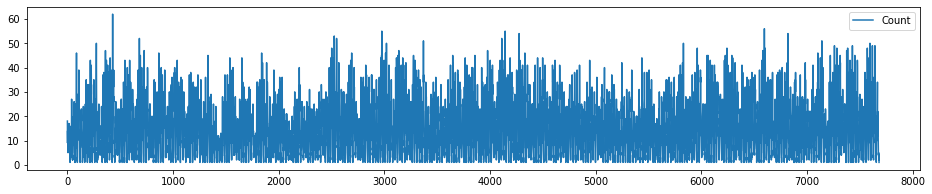

In [28]:
train_set.plot(figsize=(16,3))

There does not appear any seasonality or trend in the series.

## Data cleaning and transformation

Before we can start buinding a model, we need to ensure the data is **stationary**. We will use the Augmented Dickey-Fuller (ADF) test and the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests to test the series for stationarity.

In [29]:
from statsmodels.tsa.stattools import adfuller, kpss

adf_pval = adfuller(train_set['Count'], maxlag=10, regression='nc')[1]

print("ADF, p-value:", adf_pval)

ADF, p-value: 5.622377150770526e-24


In [30]:
kpss_stat, kpss_pval, lags, crit_vals = kpss(train_set['Count'])

/Users/Edite/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [31]:
print("KPSS, p-value:", kpss_pval)

KPSS, p-value: 0.01


The series is not stationary in the levels (i.e., in the original form), according to the ADF test, but it is stationary according to the KPSS test. So it would be safer to assume that the series is not stationary. Let us difference it.

In [32]:
train_diff = train_set['Count'].diff().dropna()

adf_pval = adfuller(train_diff, maxlag=10, regression="nc")[1]
print("ADF, p-value:", adf_pval)

ADF, p-value: 0.0


In [33]:
kpss_stat, kpss_pval, lags, crit_vals = kpss(train_diff)
print("KPSS, p-value:", kpss_pval)

KPSS, p-value: 0.1


/Users/Edite/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


The series has become stationary after the first differencing, so we'll use a differenced training set for building a model and we'll also difference the test data in order to be able to evaluate the model.

In [34]:
test_diff = test_set['Count'].diff().dropna()

## Build models

### Baseline

The persistence baseline is generating the previous day's sales as the prediction for this day.

In [35]:
baseline_predictions = test_diff.shift()[1:]

mse = mean_squared_error(test_diff[1:], baseline_predictions)

baseline_rmse = np.sqrt(mse)
baseline_rmse

10.566832886189484

### Extra transformation steps

We need to do some transformation steps required to be able to input the data into the scikit-learn's implementation of the ML algorithms.

In [36]:
def create_ar_vars(ts, lags=2):
    """Create autoregressive X variables
    """
    dataX, dataY = [], []
    for i in range(len(ts)-lags):
        dataX.append(ts[i:i + lags, 0])
        dataY.append(ts[i + lags, 0])
    return np.array(dataX), np.array(dataY)

We first create separate arrays for the predictors and the target, for both the training and test data. We'll use 3 lags to create autoregressive variables.

In [37]:
Xtrain, ytrain = create_ar_vars(train_diff.values.reshape(-1, 1), lags=3)
Xtest, ytest = create_ar_vars(test_diff.values.reshape(-1, 1), lags=3)

Both predictor arrays need to be scaled (but the target variable should not be transformed).

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

Then we can use a grid search to find the most optimal hyperparameters settings.

### Decision Tree regression

We'll fine-tune `min_samples_split` (the minimum number of instances required to be at a node before it gets split) and `max_depth` (the maximum depth of each tree).

In [39]:
dtree = DecisionTreeRegressor(random_state=7)
param_grid = [
    {'max_depth': [2, 3, 4, 6, 8, None],
    'min_samples_split': [2, 4, 6, 8]}
]

tscv = TimeSeriesSplit(n_splits=5)
dtree_grid_search = GridSearchCV(estimator=dtree, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
dtree_grid_search.fit(Xtrain, ytrain)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 0.686 seconds


In [40]:
val_scores = dtree_grid_search.cv_results_["mean_test_score"]
train_scores = dtree_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in dtree_grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

7.115521576810344 6.7301399704068 {'max_depth': 4, 'min_samples_split': 4}
7.115521576810344 6.7301399704068 {'max_depth': 4, 'min_samples_split': 2}
7.115521576810344 6.730299842918821 {'max_depth': 4, 'min_samples_split': 6}
7.120182670876918 6.732384782766594 {'max_depth': 4, 'min_samples_split': 8}
7.131079534419739 6.469150560390318 {'max_depth': 6, 'min_samples_split': 8}
7.152664888585318 6.452828248417701 {'max_depth': 6, 'min_samples_split': 6}
7.1830151115782765 6.4317608754627225 {'max_depth': 6, 'min_samples_split': 2}
7.186592478434336 6.438900759948303 {'max_depth': 6, 'min_samples_split': 4}
7.212511384044695 6.1920611728598765 {'max_depth': 8, 'min_samples_split': 8}
7.217467179813765 6.890041795140688 {'max_depth': 3, 'min_samples_split': 8}
7.217467179813765 6.890041795140688 {'max_depth': 3, 'min_samples_split': 6}
7.217467179813765 6.890041795140688 {'max_depth': 3, 'min_samples_split': 4}
7.217467179813765 6.890041795140688 {'max_depth': 3, 'min_samples_split': 2}


### Random Forest regression

We'll fine-tune `n_estimators` (the number of decision trees used in the random forest) as well as `min_samples_split` and `max_depth` (hyperparameters of specific trees).

In [41]:
rf = RandomForestRegressor(random_state=7)
param_grid = [
    {'n_estimators': [2, 3, 5, 10], 
     'max_depth': [2, 4, 6, 8],
     'min_samples_split': [4, 6, 8, 10]
    },
]

tscv = TimeSeriesSplit(n_splits=5)
rf_grid_search = GridSearchCV(estimator=rf, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
rf_grid_search.fit(Xtrain, ytrain)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 5.781 seconds


Let's print the accuracy scores for every model evaluated during the grid search.

In [42]:
val_scores = rf_grid_search.cv_results_["mean_test_score"]
train_scores = rf_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in rf_grid_search.cv_results_["params"]]
   
for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

6.915872169070457 6.41278494037545 {'max_depth': 6, 'min_samples_split': 8, 'n_estimators': 10}
6.91668574042748 6.42288378569243 {'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 10}
6.920040526692828 6.165545692207578 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 10}
6.922146380117927 6.400955751195799 {'max_depth': 6, 'min_samples_split': 6, 'n_estimators': 10}
6.922370051547146 6.391001982042908 {'max_depth': 6, 'min_samples_split': 4, 'n_estimators': 10}
6.92428849201159 6.138697133930305 {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 10}
6.929959834793768 6.106529474290139 {'max_depth': 8, 'min_samples_split': 6, 'n_estimators': 10}
6.941137140448905 6.074169443361317 {'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 10}
6.96374839676334 6.463059482973225 {'max_depth': 6, 'min_samples_split': 8, 'n_estimators': 5}
6.966411572656291 6.4723992723926935 {'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 5}
6.97126784176049 6.45630007922903

The best models with both DT and RF methods do not seem to overfit too much, and their cross-validation RMSEs are quite above the baseline.

## Evaluate the best DT and RF models on the test data

#### Decision tree

In [43]:
best_model = dtree_grid_search.best_estimator_

yhat = best_model.predict(Xtest)

dtree_mse = mean_squared_error(ytest, yhat)
dtree_rmse = np.sqrt(dtree_mse)
dtree_rmse

7.4742039469590775

In [44]:
best_model = rf_grid_search.best_estimator_

yhat = best_model.predict(Xtest)

rf_mse = mean_squared_error(ytest, yhat)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

7.22972627890615

In [45]:
100*(baseline_rmse - dtree_rmse)/baseline_rmse

29.26732136809294

By how much did the RF model improve on the persistence baseline, percent-wise?

In [46]:
100*(baseline_rmse - rf_rmse)/baseline_rmse

31.580953756208512

## Conclusion

The Decision Tree regression model reduced the RMSE rate by 42%, while the RandomForest regression method by 45.2%, compared to the persistence baseline.

# Random Forest Regressor

In [47]:
# drop labels for training set, but keep all others
Xtrain = df2.drop(["Count", 'High_Winds', 'datetime'], axis=1)

ytrain = df2["Count"].copy()

In [48]:
df2.sample(10).T

,5376,7219,3277,1584,1004,630,1855,8274,2110,5838
datetime,2018-08-19 05:00:00,2018-11-05 17:00:00,2018-05-21 19:00:00,2018-03-10 09:00:00,2018-02-13 07:00:00,2018-01-28 01:00:00,2018-03-22 01:00:00,2018-12-20 16:00:00,2018-04-01 23:00:00,2018-09-08 01:00:00
Count,4,45,13,9,19,6,2,25,13,7
High_Winds,False,False,False,False,False,False,False,False,False,False
Hour,5,17,19,9,7,1,1,16,23,1
Dayofweek,7,1,1,6,2,7,4,4,7,6
Quarter,3,4,2,1,1,1,1,4,2,3
Month,8,11,5,3,2,1,3,12,4,9
Dayofmonth,19,5,21,10,13,28,22,20,1,8
Weekofyear,33,45,21,10,7,4,12,51,13,36
Weekend,1,0,0,1,0,1,0,0,1,1


In [49]:
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

# specify the hyperparameters and their values

param_grid = [
    {'n_estimators': [2, 3, 5, 10], 
     'max_depth': [2, 4, 6, 8, None],
     'min_samples_split': [2, 4, 6, 8]
    },
]
forest_reg = RandomForestRegressor(random_state=7)

# we'll use 10-fold cross-validation
rf_grid_search = GridSearchCV(forest_reg, param_grid, cv=10, 
                              scoring='neg_mean_squared_error',
                              return_train_score=True)

rf_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=7,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [50]:
# the best model

rf_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

In [51]:
# the best model's RMSE

np.sqrt(-rf_grid_search.best_score_)

5.288623368257133

In [52]:
# training and validation RMSE

val_scores = rf_grid_search.cv_results_["mean_test_score"]
train_scores = rf_grid_search.cv_results_["mean_train_score"]
params = rf_grid_search.cv_results_["params"]

for val_score, train_score, param in zip(val_scores, train_scores, params):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

7.362554893571152 7.333745672186265 {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 2}
7.3661443607729895 7.3338271031751034 {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 3}
7.362097083392584 7.333351297892602 {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 5}
7.3598544439932745 7.333150232721527 {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10}
7.362554893571152 7.333745672186265 {'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 2}
7.3661443607729895 7.3338271031751034 {'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 3}
7.362097083392584 7.333351297892602 {'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 5}
7.3598544439932745 7.333150232721527 {'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 10}
7.362554893571152 7.333745672186265 {'max_depth': 2, 'min_samples_split': 6, 'n_estimators': 2}
7.3661443607729895 7.3338271031751034 {'max_depth': 2, 'min_samples_split': 6, 'n_estimators': 3}
7.362097083392584 7.3333512978

**Comments**: The best model is achieved with n_estmators=200. Comparing the mean RMSE on the training set and the validation set, we notice that the latter is around three times lower than the former. This indicates the models overfit and we should constrain the learned trees in some way (e.g., introduce the maximum tree depth) to reduce it. This in turn may help to reduce the RMSE on the validation set.

### Support Vector Regressor

In [53]:
from sklearn.svm import SVR

param_grid = [
    {'C': [0.1, 0.01, 1], 
     'gamma': [0.1, 0.5, 0.9]
    },
]

svr = SVR(kernel="rbf")

sv_grid_search = GridSearchCV(svr, param_grid, cv=10, 
                              scoring='neg_mean_squared_error',
                              return_train_score=True)

sv_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 0.01, 1], 'gamma': [0.1, 0.5, 0.9]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [54]:
# the best model

sv_grid_search.best_estimator_

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [55]:
# the best model's RMSE

np.sqrt(-sv_grid_search.best_score_)

10.028979839073946

In [56]:
# training and validation RMSE

val_scores = sv_grid_search.cv_results_["mean_test_score"]
train_scores = sv_grid_search.cv_results_["mean_train_score"]
params = sv_grid_search.cv_results_["params"]

for val_score, train_score, param in zip(val_scores, train_scores, params):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

10.503232524686206 9.84779696563859 {'C': 0.1, 'gamma': 0.1}
10.577963874544533 10.41228875752028 {'C': 0.1, 'gamma': 0.5}
10.5782994605318 10.459153751078416 {'C': 0.1, 'gamma': 0.9}
10.562040717869625 10.490624687357224 {'C': 0.01, 'gamma': 0.1}
10.573939185182883 10.552397822780124 {'C': 0.01, 'gamma': 0.5}
10.573953026841904 10.55705703339121 {'C': 0.01, 'gamma': 0.9}
10.028979839073946 6.486414611287232 {'C': 1, 'gamma': 0.1}
10.618373770828153 9.083959893873361 {'C': 1, 'gamma': 0.5}
10.597476068937048 9.493609110004847 {'C': 1, 'gamma': 0.9}


**Comments**: The best RMSE was achieved with C=10000 and gamma=0.1. There is no evidence of overfitting with this model: the performance on the training data is similar to that on the validation data.

Indeed, the predictions are spot on! But, these are predictions on training data. Decision trees are powerful models, capable of capturing complex patterns in the data, but at the same time they will **overfit**, unless they are contrained in some way (e.g. a maximum tree depth is set). To confirm this, we would need to see how the model fares on the test data, but this needs to be postponed till after we have selected the most promising models for the eventual evaluation on the test set.

Another possibility is to evaluate the model using **cross-validation**.

## 5.3 Cross-validation

The idea behind cross-validation is the following: take the training set, split it into $k$ parts (e.g., $k$=10). Then train a model on the $k-1$ parts and evaluate the model on the $k$-th part. Repeat this $k$ times, each time recording the accuracy score. The final accuracy score is the mean of the accuracy scores of the $k$ models.

In scikit-learn, this can be achieved as follows.

### Decision trees

In [57]:
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor()

# Scikit-Learn cross-validation features expect a utility function (greater is better) 
# rather than a cost function (lower is better), so the scoring function is actually 
# the opposite of the MSE
scores = cross_val_score(tree_reg, Xtrain, ytrain, scoring="neg_mean_squared_error", cv=10)

rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [7.27799384 6.81631024 6.6054157  7.54276905 6.97048619 6.77306486
 6.79297797 6.73174203 7.11546859 7.74121781]
Mean: 7.036744627675084
Standard deviation: 0.35745541683669946


Thus, the Decision Tree algorithm produces models that have the RMSE of 64,811; the standard deviation being 2,166 (which gives an idea of the variance of the algorithm).

So we can confirm that our original model, which was evaluated on the training set, overfitted the data.

# Linear regression

For comparison, let's also evaluate the linear regression using cross-validation:

In [58]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, Xtrain, ytrain,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [ 7.39985632  6.9719456   6.92972555  7.2900386   7.31181112  6.15297012
  6.2679948   7.2965199   7.21361275 37.73364015]
Mean: 10.056811491102867
Standard deviation: 9.234984985593098


It turns out that linear regression has a slightly lower average error rate than Decision Trees, and at the same time exhibits lower variance.

### Random Forest

Finally, let's evaluate a RandomForest regression algorithm. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions.

We specify that we want the algorithm to use 10 decision trees. We do that by passing `n_estimators=10` when we initialize the `RandomForestRegressor` class 

In [59]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=7)
scores = cross_val_score(forest_reg, Xtrain, ytrain,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [5.67243689 5.24126106 5.76604705 5.30643555 5.73682087 4.84145923
 5.03147911 5.34288183 5.48682018 6.45634395]
Mean: 5.488198573623224
Standard deviation: 0.4303790525981547


The algorithm produced a much lower RMSE score (47,820) than either Decision Trees or linear regression methods. It seems to be a particularly suitable algorithm to be explored further.

## 5.4 Tuning hyperparameters


In the previous experiment, we used 10 decision trees in the Random Forest algorithm. This setting is called a hyperparameter of the algorithm, and needs to be set before a model is trained.

We might experiment with several different settings of the hyperparameter to find its optimal settings. However, many algorithms have quite a few of such hyperparameters. Scikit-learn has a utility to automatically search for the best combination of hyperparameter values, implemented in the `GridSearchCV` class. 

### Exhaustive grid search

`GridSearchCV` takes a set of hyperparameters and the search range for each hyperparameter, constructs a search grid with all possible hyperparameter combinations, and evaluates each combination using cross-validation. The output is the model with the best cross-validation accuracy.

Let's take a look at an example. We will train a RandomForest regressor, searching for the best model in the grid created from two hyperparameters: `n_estimators` (the number of decision trees, trying values 3, 10 and 30) and `max_depth` (the maximum depth of each tree, trying values 4, 6, 8 and None - None being the maximum possible depth, the default value). So, the grid search will involve creating and evaluating 12 models using cross-validation.

In [60]:
from sklearn.model_selection import GridSearchCV

# specify the hyperparameters and their values
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_depth': [4, 6, 8, None]},
]

forest_reg = RandomForestRegressor(random_state=7)

# we'll use 10-fold cross-validation
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=7,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

Once grid search is complete we can obtain the best model and its accuracy score: they are attributes on the `GridSearchCV` class:

In [61]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

The best model proved to be one with `n_estimator=30` and `max_depth=None`.

Let's look up its RMSE.

In [62]:
np.sqrt(-grid_search.best_score_)

5.280166386158648

Thus by tuning hyperparameters, we were able to further reduce the error rate (from 47820 to 46209). 

You could have noticed that the largest value of `n_estimators` we tried (30) produced the best result. This suggests we should try even greater values - we could improve the error rate further.

We can also access RMSE scores of each model trained during grid search. They are stored in the `cv_results_` attribute:

In [63]:
val_scores = grid_search.cv_results_["mean_test_score"]
train_scores = grid_search.cv_results_["mean_train_score"]
params = grid_search.cv_results_["params"]

for val_score, train_score, param in zip(val_scores, train_scores, params):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

6.3503087374566975 6.234214825140809 {'max_depth': 4, 'n_estimators': 3}
6.15733059579028 6.059659873980068 {'max_depth': 4, 'n_estimators': 10}
6.181004831072239 6.080228343526752 {'max_depth': 4, 'n_estimators': 30}
5.40669284431263 5.217849621324575 {'max_depth': 6, 'n_estimators': 3}
5.422853605816026 5.218424228663404 {'max_depth': 6, 'n_estimators': 10}
5.4120320482510325 5.210811615381205 {'max_depth': 6, 'n_estimators': 30}
5.382164476885319 4.728851852036687 {'max_depth': 8, 'n_estimators': 3}
5.291793740652879 4.705895295198278 {'max_depth': 8, 'n_estimators': 10}
5.280166386158648 4.676004350537132 {'max_depth': 8, 'n_estimators': 30}
5.99490429875337 2.616594437489425 {'max_depth': None, 'n_estimators': 3}
5.5050476575989125 2.0199246116929337 {'max_depth': None, 'n_estimators': 10}
5.434122158645126 1.819630202256117 {'max_depth': None, 'n_estimators': 30}


The best-performing model showed a much lower RMSE on the training set (17985) than on the test set (46209). This indicates the model overfitted the training data. The overfitting could be reduced and the model further improved by introducing constraints on the learned trees (for example, enforcing a maximum depth of the learned trees).

### Randomized grid search

When the search space of hyperparameters is very large, running exhaustive grid search may take too much time. In such cases, one can try `RandomizedSearchCV` instead. It allows to limit the number of models to build and thus control the amount of computing resources one uses.

The class works very much the same as `GridSearchCV`, but takes extra arguments: `n_iter`, the number of random combinations to try and `random_state`, which can be set to the same constant to ensure that the same random combinations are tried in different runs of the code.

Here, we will try 6 random combinations (`n_iter=6`), instead of 12 in the exhaustive search.

In [64]:
from sklearn.model_selection import RandomizedSearchCV

# specify the hyperparameters and their values
param_grid = {'n_estimators': [3, 10, 30], 'max_depth': [4, 6, 8, None]}

forest_reg = RandomForestRegressor(random_state=7)

# we'll use 10-fold cross-validation
rand_grid_search = RandomizedSearchCV(forest_reg, param_grid, cv=10, n_iter=6,
                                     scoring='neg_mean_squared_error', random_state=7,
                                     return_train_score=True)

rand_grid_search.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [65]:
rand_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

The best model found is with `n_estimators=10` and `max_depth=None`.

Its RMSE score is:

In [66]:
np.sqrt(-rand_grid_search.best_score_)

5.291793740652879

## 5.5 Analyze the most promising models

We can examine what variables were the most important for the regression problem in the best-performing model. They are also stored as an attribute on the model object:

In [67]:
# put them into a separate variable for convenience
feature_importances = grid_search.best_estimator_.feature_importances_

# the order of the features in `feature_importances` is the same as in the Xtrain dataframe,
# so we can "zip" the two and print in the descending order:

for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k}")

Hour: 0.769271682364635
Weekend: 0.07530736805840361
Time_of_Day_Office hours (10-15): 0.03869658204829355
Weekofyear: 0.03593362233614116
Time_of_Day_Morning rush (5-10): 0.02558458044758602
Time_of_Day_Evening (19-23): 0.0190519083667776
Dayofweek: 0.008914082722078314
Dayofmonth: 0.006298281856612224
Day_of_Week_Saturday: 0.00420439297224768
Month: 0.0030768577743843146
Light_Conditions_Darkness - lights lit: 0.002601928100891391
Urban_or_Rural_Area_Urban: 0.0023432615755310856
Precipitation_Raining: 0.0020007365006510123
Day_of_Week_Sunday: 0.0015188336440423614
Light_Conditions_Daylight: 0.0011165090181389364
Quarter: 0.0008471137092278127
Time_of_Day_Night (23-5): 0.00047720794197373496
Road_Surface_Conditions_Wet or damp: 0.00047192865824703965
Road_Surface_Conditions_Snow: 0.00042040419869327823
Road_Surface_Conditions_Frost or ice: 0.00038896565792943957
Precipitation_Snowing: 0.0003440080981788336
Day_of_Week_Tuesday: 0.0002779134954675544
Day_of_Week_Monday: 0.00025399491635

We can notice that median income is by far the most useful variable for predicting the price of housing. Other useful features are the position of the district relative to the ocean, the average number of persons per household in a district.

There are some features that are much less useful: "NEAR OCEAN", "NEAR BAY" and "ISLAND". We may consider removing them both from the training and test set.

It often helps to also visualize the predictions made by the model. Let's refit the best model on the first 90% of the training set and generate predictions on the last 10%. There are 15736 training instances, so we will use 14162 for training and the rest for testing.